In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import *
from scipy.interpolate import Rbf
from numpy import random

### Consider the Bilinear DC Motor given by the equations:

$\dot{x_1} = -(R_a/L_a)x_1-(k_m/L_a)x_2u+u_a/L_a$

$\dot{x_2} = -(B/J)x_2+(k_m/J)x_1u-\tau_1/J$

$y = x_2$

In [2]:
# define the dynamics
# x1 - current in [-1,1]
# x2 - angular velocity in [-1,1]
# u  - control input in [-1,1]

def dyn_motor_scaled(t,x,u):
    
    dx1dt = -39.3153*x[0]-32.2293*x[1]*u+19.10828025
    dx2dt = -1.6599*x[1]+22.9478*x[0]*u-3.333333333
    
    dXdt = np.asarray([dx1dt,dx2dt])
    
    return dXdt

In [3]:
# define some relevant parameters

dt = 0.01 # sampling time
nstates = 2 # number of states
nctrl = 1 # number of control inputs

### Define Some Helper Functions

In [4]:
# RK4

k1 = lambda t,x,u: dyn_motor_scaled(t,x,u)
k2 = lambda t,x,u: dyn_motor_scaled(t,x+k1(t,x,u)*dt/2,u)
k3 = lambda t,x,u: dyn_motor_scaled(t,x+k2(t,x,u)*dt/2,u)
k4 = lambda t,x,u: dyn_motor_scaled(t,x+k1(t,x,u)*dt,u)

rk4_step = lambda t,x,u: x+(dt/6)*(k1(t,x,u)+2*k2(t,x,u)+2*k3(t,x,u)+k4(t,x,u))

In [5]:
# define the Radial Basis Function that will aid in lifting the states
def rbf(X,C,rbf_type):
    
    Cbig = C ; Y = np.zeros([C.shape[1],X.shape[1]])
    
    for i in range(Cbig.shape[1]):
        
        C = np.asarray([Cbig[:,i]]).T
        C = np.tile(C,X.shape[1])
        r_squared = np.sum((X-C)**2,axis = 0)
        
        r_squared = np.reshape(r_squared,(1,len(r_squared)))
        y = r_squared*np.log(np.sqrt(r_squared))
        
        Y[i,:] = y
    
    return Y

In [11]:
# helps create the random binary wave which acts as the control input
def myprbs(N,dutyCycle):
    
    N = np.asarray([N,1])
        
    y = np.random.uniform(0,1,N)
    y = np.double(y > (1 - dutyCycle))
    
    return y

### Collect Data

In [30]:
Nsim = 1000
Ntraj = 200

# Random forcing
Ubig = 2*np.random.uniform(0,1,[Nsim,Ntraj]) - 1

Cy = np.asarray([[0, 1]]) # Output matrix: y = Cy*x
nD = 1 # Number of delays
ny = Cy.shape[0] # Number of outputs

# Random initial conditions
Xcurrent = (np.random.uniform(0,1,[nstates,Ntraj])*2 - 1)
X = np.empty([nstates+nctrl,Nsim*Ntraj-Ntraj]); Y = np.empty([nstates+nctrl,Nsim*Ntraj-Ntraj])
U = np.empty([nctrl,Nsim*Ntraj-Ntraj])

zeta_current = np.vstack([np.dot(Cy,Xcurrent),np.empty([nD*(ny+nctrl),Ntraj])])

# Delay-embedded "state" 
# zeta_k = [y_{k} ; u_{k-1} ; y_{k-1} ... u_{k-nd} ; y_{k-nd} ]
n_zeta = (nD+1)*ny + nD*nctrl # dimension of the delay-embedded "state"
for i in range(Nsim-nD):
    Xnext = rk4_step(0,Xcurrent,Ubig[i,:])
    zeta_prev = zeta_current
    zeta_current = np.vstack([np.dot(Cy,Xnext),np.asarray([Ubig[i,:]]),zeta_current[:-ny-nctrl,:]])
    if(i>nD-1):
        X[:,(i-1)*Ntraj:i*Ntraj] = zeta_prev
        Y[:,(i-1)*Ntraj:i*Ntraj] = zeta_current
        U[0,(i-1)*Ntraj:i*Ntraj] = Ubig[i,:]
    Xcurrent = Xnext

In [7]:
Nrbf = 100 # number of RBF centers
cent = np.random.uniform(0,1,[n_zeta,Nrbf])*2-1 # generate random RBF centers
rbf_type = 'thin_plate' # specify the type of RBF

# obtain the lifted states
liftFun = lambda xx,cent: np.vstack([xx,rbf(xx,cent,rbf_type)])
# update the total dimension of the lifted state vector
Nlift = Nrbf+n_zeta

### Lift

In [8]:
Xlift = liftFun(X,cent)
Ylift = liftFun(Y,cent)

print(Xlift.shape,Ylift.shape) # print out shapes as a sanity check

(103, 199800) (103, 199800)


### Build Predictor

In [9]:
W = np.vstack([Ylift,X])
V = np.vstack([Xlift,U])

VVt = np.dot(V,V.T)
WVt = np.dot(W,V.T)
M = np.dot(WVt,np.linalg.pinv(VVt)) # Matrix [A B; C 0]
Alift = M[0:Nlift,0:Nlift]
Blift = M[0:Nlift,Nlift:]
Clift = M[Nlift:,0:Nlift]

print(Alift.shape, Blift.shape, Clift.shape) # print out dimensions as a sanity check

(103, 103) (103, 1) (3, 103)


In [10]:
residual = np.linalg.norm(Ylift - np.dot(Alift,Xlift) - np.dot(Blift,U),'fro') / np.linalg.norm(Ylift,'fro')
print(residual)

0.08246011644504031


### Check Predictor Performance

In [18]:
Tmax = 1
Nsim = int(Tmax/dt)
n = np.arange(0,Nsim)*dt

uprbs = (2*myprbs(Nsim,0.5) - 1)

#x0 = np.random.uniform(0,1,[2,1])-0.5;
x0 = np.asarray([[0.887,0.587]]).T
x = x0

# Delayed initial condition (assume random control input in the past)
xstart = np.vstack([np.dot(Cy,x),np.empty([nD*(ny+nctrl),1])])

for i in range(nD):
    urand = 2*np.random.uniform(0,1,[nctrl]) - 1
    xp = rk4_step(0,x,urand)
    xstart = np.vstack([np.dot(Cy,xp),np.asarray([urand]),xstart[:-ny-nctrl]])
    x = xp

In [19]:
# Inital conditions
x_true = xp
xlift = liftFun(xstart,cent)

# Simulation
for i in range(Nsim-1):
    
    # True dynamics
    x_true = np.hstack([x_true, rk4_step(0,np.asarray([x_true[:,-1]]).T,uprbs[i,:])]) 
    
    # Koopman predictor
    term1 = np.dot(Alift,np.asarray([xlift[:,-1]]).T)
    term2 = np.dot(Blift,np.asarray([uprbs[i,:]]))
    xlift = np.hstack([xlift, term1 + term2]) # Lifted dynamics
    
x_koop = np.dot(Clift, xlift) # Koopman predictions
x_koop = x_koop[0,:]
x_true = np.dot(Cy,x_true).T

### Plot Results

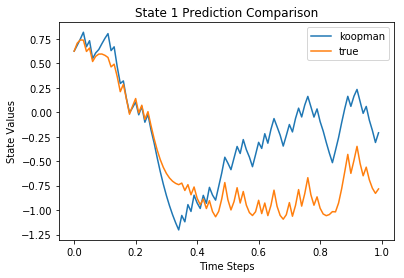

In [20]:
plt.plot(n,x_koop,label="koopman")
plt.plot(n,x_true,label="true")
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("State Values")
plt.title("State 1 Prediction Comparison")
plt.show()

## Test 2

In [27]:
Nsim_test = 2000 
# random forcing
u_test = (2*myprbs(Nsim_test,0.5) - 1)
#u_test = 2*np.random.uniform(0,1,[Nsim_test,1])-1
# random forcing sample
u_test_sample = u_test[0:nctrl,:]
# random initial condition
x0_test = np.random.uniform(0,1,[nstates,1])*2 - 1
delay_init = np.vstack([x0_test,u_test_sample])

# Inital conditions
x_true = x0_test
xlift = liftFun(delay_init,cent)
print(xlift.shape)

# Simulation
for i in range(Nsim_test-1):
    
    # True dynamics
    x_true = np.hstack([x_true, rk4_step(0,np.asarray([x_true[:,-1]]).T,u_test[i,:])]) 
    
    # Koopman predictor
    term1 = np.dot(Alift,np.asarray([xlift[:,-1]]).T)
    term2 = np.dot(Blift,np.asarray([u_test[i,:]]))
    xlift = np.hstack([xlift, term1 + term2]) # Lifted dynamics
    
x_koop = np.dot(Clift, xlift) # Koopman predictions
x_koop = x_koop[0,:]
x_true = np.dot(Cy,x_true).T

(103, 1)


## Plot Results

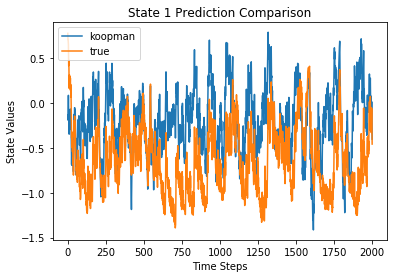

In [28]:
plt.plot(x_koop,label="koopman")
plt.plot(x_true[:,0],label="true")
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("State Values")
plt.title("State 1 Prediction Comparison")
plt.show()